# Support Vector Machine (SVM) - Multiclass Classification
If you want additional information on the features in the data, please visit here: https://archive.ics.uci.edu/ml/datasets/Urban+Land+Cover

_Please note, the link above has datasets labeled backwards from the assignment data. But, it does include information on each feature._ 

For assignment \#5 we will be working with UCI's Urban Land Cover Data Set. This is the classification of urban land cover with 9 different classes that are fairly balanced across train & test. Multi-scale spectral, size, shape, and texture information are used for classification.

You will need to use the `SVC` & `LinearSVC` classifiers from `sklearn.svm`. You will also need to use `RandomForestClassifier` (from HW #4) to compare performance of this model to support vector machine models.

You will need to use the `SVC` & `LinearSVC` classifiers from `sklearn.svm`. You will also need to use `RandomForestClassifier` (from HW \#4) to compare performance of this model to support vector machine models.

# Load Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, style
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import sklearn.metrics as metrics
import sklearn.preprocessing as preprocessing
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")

/Users/joshuagoldberg/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# 1. Data Processing

a) Import the data: You are provided separate .csv files for train and test.

In [2]:
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")

b) Remove any rows that have missing data across both sets of data.

In [3]:
train_data.replace(["NaN", "NaT"], np.nan, inplace=True)
train_data = train_data.dropna(how="any", axis=0)

test_data.replace(["NaN", "NaT"], np.nan, inplace=True)
test_data = test_data.dropna(how="any", axis=0)

train_data.head()

,class,BrdIndx,Area,Round,Bright,Compact,ShpIndx,Mean_G,Mean_R,Mean_NIR,...,SD_NIR_140,LW_140,GLCM1_140,Rect_140,GLCM2_140,Dens_140,Assym_140,NDVI_140,BordLngth_140,GLCM3_140
0,concrete,1.32,131,0.81,222.74,1.66,2.18,192.94,235.11,240.15,...,31.15,5.04,0.80,0.58,8.56,0.82,0.98,-0.10,1512,1287.52
1,shadow,1.59,864,0.94,47.56,1.41,1.87,36.82,48.78,57.09,...,12.01,3.70,0.52,0.96,7.01,1.69,0.86,-0.14,196,2659.74
2,shadow,1.41,409,1.00,51.38,1.37,1.53,41.72,51.96,60.48,...,18.75,3.09,0.90,0.63,8.32,1.38,0.84,0.10,1198,720.38
3,tree,2.58,187,1.91,70.08,3.41,3.11,93.13,55.20,61.92,...,27.67,6.33,0.89,0.70,8.56,1.10,0.96,0.20,524,891.36
4,asphalt,2.60,116,2.05,89.57,3.06,3.02,73.17,94.89,100.64,...,32.05,1.01,0.83,0.75,8.62,2.08,0.08,-0.10,496,1194.76


c) The target variable (dependent variable) is called `class`. Make sure to separate this out into a `y_train` and `y_test` and remove from your `X_train` and `X_test`

In [4]:
y_train = train_data["class"]
y_test = test_data["class"]

X_train = train_data.drop(["class"], axis=1)
X_test = test_data.drop(["class"], axis=1)

In [5]:
y_train.head()

0    concrete 
1      shadow 
2      shadow 
3        tree 
4     asphalt 
Name: class, dtype: object

d) Scale all features / predictors (NOT THE TARGET VARIABLE)
_Note: We need to scale here due to `SVM`._

In [5]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Random Forest Classifier - Base Model 
Start by creating a simple Random Forest only using default parameters - this will let us compare SVMs to Random Forest in multi-class problems.

a) Use the `RandomForestClassifier` in `sklearn`. Fit your model on the training data.

In [6]:
rf_mod_base = RandomForestClassifier().fit(X_train_scaled, y_train)

b) Use the fitted model to predict on test data. Use the `.predict()` method to get the predicted classes.

In [7]:
y_test_prob_base = rf_mod_base.predict_proba(X_test_scaled)
y_test_pred = rf_mod_base.predict(X_test_scaled)

c) Calculate the confusion matrix and classification report (both are in `sklearn.metrics`).

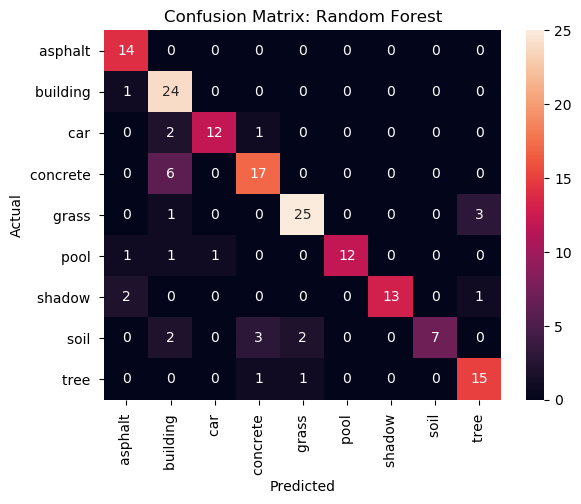

             precision    recall  f1-score   support

   asphalt        0.78      1.00      0.88        14
  building        0.67      0.96      0.79        25
       car        0.92      0.80      0.86        15
  concrete        0.77      0.74      0.76        23
     grass        0.89      0.86      0.88        29
      pool        1.00      0.80      0.89        15
    shadow        1.00      0.81      0.90        16
      soil        1.00      0.50      0.67        14
      tree        0.79      0.88      0.83        17

avg / total       0.85      0.83      0.83       168



In [8]:
labels_df = train_data.loc[:, train_data.columns == "class"]
labels = labels_df.drop_duplicates().sort_values("class")

conf_mat = metrics.confusion_matrix(y_true=y_test,
                                    y_pred=y_test_pred)
plt.rcdefaults()
plt.title("Confusion Matrix: Random Forest")
sns.heatmap(conf_mat, annot=True, fmt="d",
            xticklabels=labels["class"],
            yticklabels=labels["class"])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

print(metrics.classification_report(y_test, y_test_pred))

d) Identify the top 5 features. Feel free to print a list OR to make a plot. 

name           score
Bright_60  0.0392898
NDVI_40    0.0349789
Mean_R_40  0.0346287
NDVI_100   0.0331724
NDVI       0.0316217


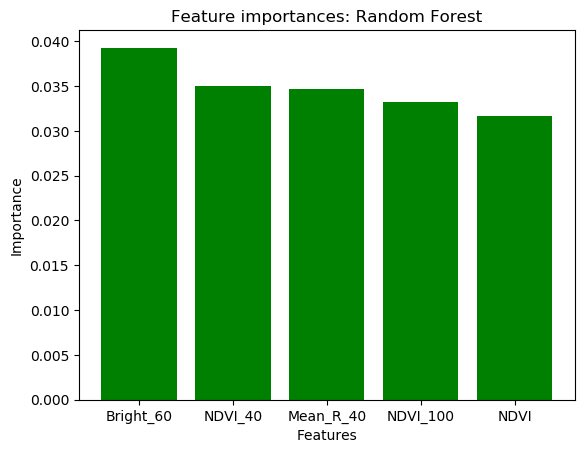

In [9]:
importances = rf_mod_base.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_mod_base.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking    
headers = ["name", "score"]
values = sorted(zip(X_test.columns, importances), key=lambda x: x[1] * -1)
print(tabulate(values[0:5], headers, tablefmt="plain"))

# Plot the feature importances of the forest
plt.rcdefaults()
plt.figure()
plt.title("Feature importances: Random Forest")
plt.bar(pd.DataFrame(values[0:5]).iloc[:, 0], importances[indices][0:5],
       color="g", align="center")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

# 3. LinearSVM Classifier - Base Model:
Create a simple `LinearSVC` Classifier only using default parameters.

a) Use the `LinearSVC` in `sklearn`. Fit your model on the training data.

In [10]:
svc_mod_base = LinearSVC().fit(X_train_scaled, y_train)

b) Use the fitted model to predict on test data. Use the `.predict()` method to get the predicted classes.

In [11]:
y_test_pred = svc_mod_base.predict(X_test_scaled)

c) Calculate the confusion matrix and classification report.

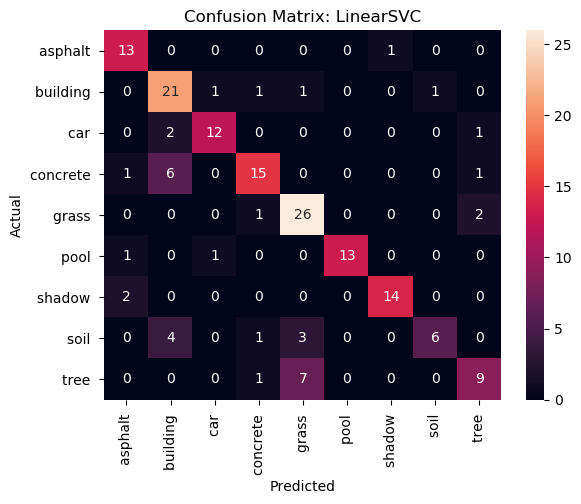

             precision    recall  f1-score   support

   asphalt        0.76      0.93      0.84        14
  building        0.64      0.84      0.72        25
       car        0.86      0.80      0.83        15
  concrete        0.79      0.65      0.71        23
     grass        0.70      0.90      0.79        29
      pool        1.00      0.87      0.93        15
    shadow        0.93      0.88      0.90        16
      soil        0.86      0.43      0.57        14
      tree        0.69      0.53      0.60        17

avg / total       0.78      0.77      0.76       168



In [12]:
conf_mat = metrics.confusion_matrix(y_true=y_test,
                                    y_pred=y_test_pred)
plt.rcdefaults()
plt.title("Confusion Matrix: LinearSVC")
sns.heatmap(conf_mat, annot=True, fmt="d",
            xticklabels=labels["class"],
            yticklabels=labels["class"])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

print(metrics.classification_report(y_test, y_test_pred))

# 4. Support Vector Machine Classifier + Linear Kernel + Grid Search:

We will now use `GridSearchCV` to try various hyperparameters in a SVM with linear kernel.

a) Use `SVC` from `sklearn` with `kernel = "linear"`. Run the `GridSearchCV` using the following (SVMs run much faster than Random Forest):

* C: 0.01 - 10 in increments of 0.2 (consider using the `np.arange()` method from __numpy__ to build out a sequence of values)

* Use 5 cross-fold and the default scoring. Please set verbose = 0 to reduce the printing

Note: Feel free to try out more parameters, the above is the bare minimum for this assignment.


In [13]:
# create a dictionary of parameters
c = np.arange(0.01, 10, .2)
param_grid = {"C": c, "random_state": [0]}

# create random forest model
svc_obj = SVC(kernel="linear")

# Create gridsearch object with various combinations of parameters
svc_grid = GridSearchCV(svc_obj, param_grid, cv=5, refit=True, n_jobs=-1, verbose=0)

In [14]:
%%time
svc_grid_fit = svc_grid.fit(X_train_scaled, y_train)

CPU times: user 299 ms, sys: 61.6 ms, total: 361 ms
Wall time: 2.08 s


b) Identify the best performing model:

* `.best_params_()` : This method outputs to best performing parameters

* `.best_estimator_()` : This method outputs the best performing model, and can be used for predicting on the `X_test`

In [15]:
svc_best_model = svc_grid_fit.best_estimator_
svc_linear_best_params = svc_grid_fit.best_params_
svc_linear_best_params

{'C': 0.01, 'random_state': 0}

c) Use the best estimator model to predict on test data. Use the `.predict()` method to get the predicted classes.

In [16]:
y_test_pred_grid = svc_best_model.predict(X_test_scaled)

d) Calculate the confusion matrix and classification report.

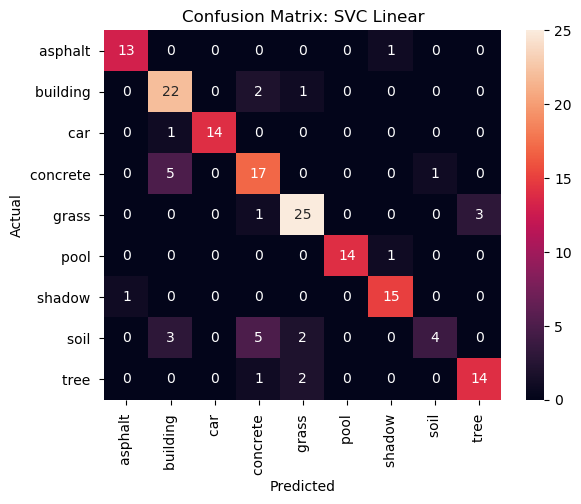

             precision    recall  f1-score   support

   asphalt        0.93      0.93      0.93        14
  building        0.71      0.88      0.79        25
       car        1.00      0.93      0.97        15
  concrete        0.65      0.74      0.69        23
     grass        0.83      0.86      0.85        29
      pool        1.00      0.93      0.97        15
    shadow        0.88      0.94      0.91        16
      soil        0.80      0.29      0.42        14
      tree        0.82      0.82      0.82        17

avg / total       0.83      0.82      0.81       168



In [17]:
conf_mat = metrics.confusion_matrix(y_true=y_test,
                                    y_pred=y_test_pred_grid)
plt.rcdefaults()
plt.title("Confusion Matrix: SVC Linear")
sns.heatmap(conf_mat, annot=True, fmt="d",
            xticklabels=labels["class"],
            yticklabels=labels["class"])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

print(metrics.classification_report(y_test, y_test_pred_grid))

# 5. Support Vector Machine Classifier + Polynomial Kernel + Grid Search:
We will now use `GridSearchCV` to try various hyperparameters in a SVM with a polynomial kernel.

a) Use `SVC` from `sklearn` with `kernel = "poly"`. Run the `GridSearchCV` using the following:

* C: 0.01 - 10 in increments of 0.2
* degree: 2, 3, 4, 5, 6

Note: Feel free to try out more parameters, the above is the bare minimum for this assignment.

In [18]:
# create a dictionary of parameters
c = np.arange(0.01, 10, .2)
degrees = np.arange(2, 6, 1)
param_grid = {"C": c, "degree": degrees, "random_state": [0]}

# create random forest model
svc_obj = SVC(kernel="poly")

# Create gridsearch object with various combinations of parameters
svc_grid = GridSearchCV(svc_obj, param_grid, cv=5, refit=True, n_jobs=-1, verbose=0)

In [19]:
%%time
svc_grid_fit = svc_grid.fit(X_train_scaled, y_train)

CPU times: user 1.25 s, sys: 146 ms, total: 1.39 s
Wall time: 13.6 s


b) Identify the best performing model:

In [20]:
svc_best_model = svc_grid_fit.best_estimator_
svc_poly_best_params = svc_grid_fit.best_params_
svc_poly_best_params

{'C': 8.41, 'degree': 3, 'random_state': 0}

c) Use the best estimator model to predict on test data. Use the `.predict()` method to get the predicted classes.

In [21]:
y_test_pred_grid = svc_best_model.predict(X_test_scaled)

d) Calculate the confusion matrix and classification report.

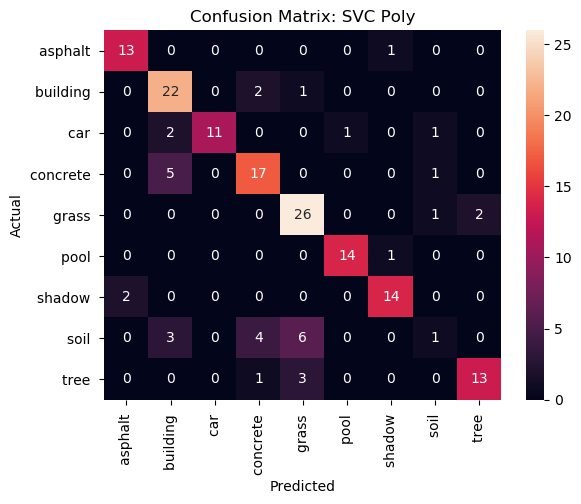

             precision    recall  f1-score   support

   asphalt        0.87      0.93      0.90        14
  building        0.69      0.88      0.77        25
       car        1.00      0.73      0.85        15
  concrete        0.71      0.74      0.72        23
     grass        0.72      0.90      0.80        29
      pool        0.93      0.93      0.93        15
    shadow        0.88      0.88      0.88        16
      soil        0.25      0.07      0.11        14
      tree        0.87      0.76      0.81        17

avg / total       0.76      0.78      0.76       168



In [22]:
conf_mat = metrics.confusion_matrix(y_true=y_test,
                                    y_pred=y_test_pred_grid)
plt.rcdefaults()
plt.title("Confusion Matrix: SVC Poly")
sns.heatmap(conf_mat, annot=True, fmt="d",
            xticklabels=labels["class"],
            yticklabels=labels["class"])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

print(metrics.classification_report(y_test, y_test_pred_grid))

# 6. Support Vector Machine Classifier + RBF Kernel + Grid Search:

We will now use `GridSearchCV` to try various hyperparameters in a SVM with a RBF kernel.

a) Use `SVC` from sklearn with `kernel = "rbf"`. Run the `GridSearchCV` using the following:

* C: 0.01 - 10 in increments of 0.2

* gamma: 0.1, 1, 10, 100

Use 5 cross-fold and the default scoring.

Note: Feel free to try out more parameters, the above is the bare minimum for this assignment.

In [23]:
# create a dictionary of parameters
c = np.arange(0.01, 10, .2)
gamma = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {"C": c, "gamma": gamma, "random_state": [0]}

# create random forest model
svc_obj = SVC(kernel="rbf")

# Create gridsearch object with various combinations of parameters
svc_grid = GridSearchCV(svc_obj, param_grid, cv=5, refit=True, n_jobs=-1, verbose=0)

In [24]:
%%time
svc_grid_fit = svc_grid.fit(X_train_scaled, y_train)

CPU times: user 1.78 s, sys: 178 ms, total: 1.96 s
Wall time: 27 s


b) Identify the best performing model:

In [25]:
svc_best_model = svc_grid_fit.best_estimator_
svc_rbf_best_params = svc_grid_fit.best_params_
svc_rbf_best_params

{'C': 4.21, 'gamma': 0.01, 'random_state': 0}

c) Use the best estimator model to predict on test data. Use the `.predict()` method to get the predicted classes.

In [28]:
y_test_pred_grid = svc_best_model.predict(X_test_scaled)

d) Calculate the confusion matrix and classification report.

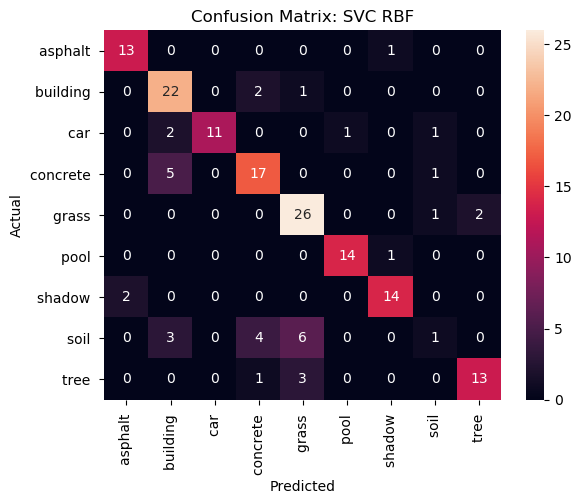

             precision    recall  f1-score   support

   asphalt        0.87      0.93      0.90        14
  building        0.69      0.88      0.77        25
       car        1.00      0.73      0.85        15
  concrete        0.71      0.74      0.72        23
     grass        0.72      0.90      0.80        29
      pool        0.93      0.93      0.93        15
    shadow        0.88      0.88      0.88        16
      soil        0.25      0.07      0.11        14
      tree        0.87      0.76      0.81        17

avg / total       0.76      0.78      0.76       168



In [26]:
conf_mat = metrics.confusion_matrix(y_true=y_test,
                                    y_pred=y_test_pred_grid)
plt.rcdefaults()
plt.title("Confusion Matrix: SVC RBF")
sns.heatmap(conf_mat, annot=True, fmt="d",
            xticklabels=labels["class"],
            yticklabels=labels["class"])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

print(metrics.classification_report(y_test, y_test_pred_grid))

# 7. From the models run in steps 2-6, which performs the best based on the Classification Report? Support your reasoning with evidence around your test data. 

To answer this question, we will compare model performance across folds for train and holdout. First, we will define some utility functions:

* `class_report`: returns a classification report in `pd.DataFrame` format that's useful for plotting

* `loop_class_reports`: a wrapper around `class_report` to iterate through models and train/test

* `cross_val_models`: iterates through models and returns a cross validation score (this is only used to evaluate train results).

In [29]:
def class_report(y_true, y_pred, model, labels, data_type):
    clf_rep = metrics.precision_recall_fscore_support(y_true, y_pred)
    out_dict = {"precision" :clf_rep[0].round(2),
                "recall" : clf_rep[1].round(2),
                "f1-score" : clf_rep[2].round(2)}
    out_df = pd.DataFrame(out_dict, index = labels)
    out_df_melted = pd.melt(out_df, var_name="Metric", value_name="Score")
    return(out_df_melted.assign(model=model, data=data_type))

def loop_class_reports(x, x_test, y, y_test, models, labels):
    class_reports_df = pd.DataFrame()
    for i, model, in enumerate(models):
        fit_model = model.fit(x, y)
        y_pred = fit_model.predict(x)
        y_pred_test = fit_model.predict(x_test)
        if i == 0:
            class_reports_df = pd.concat([class_report(y, y_pred, model_names[i], labels, 
                                            "train"), class_report(y_test, y_pred_test, 
                                                                     model_names[i], 
                                                                     labels, 
                                            "test")], sort=True)
        else :
            class_reports_df = pd.concat([
                class_reports_df, 
                pd.concat([class_report(y, y_pred, model_names[i], labels, 
                                            "train"), class_report(y_test, y_pred_test, 
                                                                     model_names[i], 
                                                                     labels, 
                                            "test")], sort=True)], sort=True)
    return(class_reports_df)

def cross_val_models(x, y, models, model_names, train_test, cv=5, scoring="accuracy"):
    cv_df = pd.DataFrame(index=range(cv * len(models)))
    entries = []
    for i, model in enumerate(models):
        model_name = model_names[i]
        accuracies = cross_val_score(model, x, y,
                                 scoring=scoring,
                                 cv=cv)
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy, train_test))
    return(pd.DataFrame(entries, columns=["Model", "fold_idx", "Accuracy", "Data"]))

Define `models` to pass to `loop_class_reports` and `cross_val_models`. We pass the generic models (`RandomForestClassifier` and `LinearSVC`), along with each `SVC` and their optimal parameters identified during grid search: 

In [30]:
models = [
    RandomForestClassifier(random_state=0),
    LinearSVC(random_state=0),
    SVC(**svc_linear_best_params, kernel="linear"),
    SVC(**svc_poly_best_params, kernel="poly"),
    SVC(**svc_rbf_best_params, kernel="rbf")
]

model_names = ["Random Forest", "LinearSVC", "SVC Linear", "SVC Poly", "SVC RBF"]

Run `loop_class_reports` and `cross_val_models` to compare model performance.

In [31]:
%%time
plot_rdy = loop_class_reports(x=X_train_scaled, x_test=X_test_scaled,
                   y=y_train, y_test=y_test, models=models, labels=labels["class"])
plot_rdy.head()

CPU times: user 1.12 s, sys: 11.3 ms, total: 1.13 s
Wall time: 685 ms


In [32]:
%%time
cv_train_df = cross_val_models(x=X_train_scaled, y=y_train, 
                               models=models, model_names=model_names, 
                               scoring="accuracy", 
                               train_test="train")
cv_train_df.head()

CPU times: user 4.25 s, sys: 30.8 ms, total: 4.28 s
Wall time: 2.06 s


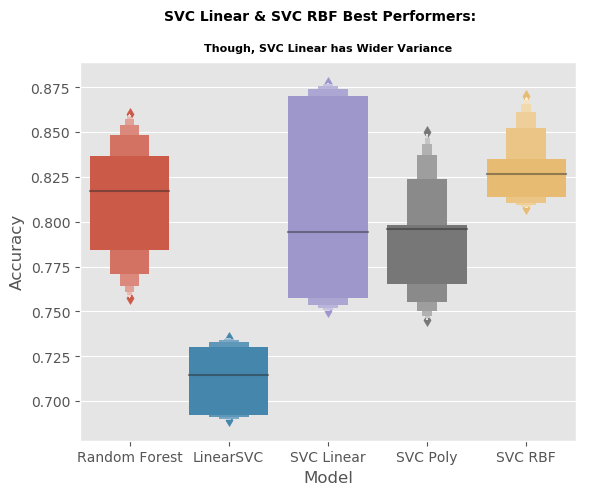

In [33]:
style.use("ggplot")
p = sns.boxenplot(x="Model", y="Accuracy", 
            data=cv_train_df)
plt.subplots_adjust(top=0.9)
plt.suptitle("SVC Linear & SVC RBF Best Performers:",
              size=10, weight="bold", ha="center", va="bottom")
plt.title("Though, SVC Linear has Wider Variance",
              size=8, weight="bold", ha="center", va="bottom")

plt.show()

`SVC RBF` has best performance for train cross validation; however, when we observe train and holdout performance together, a different story is revealed:

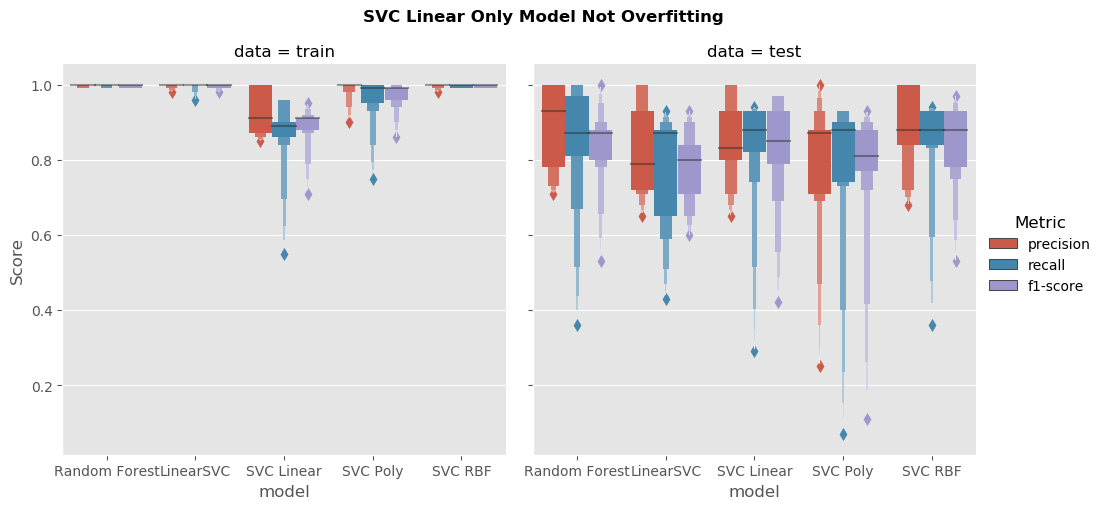

In [34]:
style.use("ggplot")
p = sns.catplot(x="model", y="Score", col="data", 
            data=plot_rdy, hue="Metric", kind="boxen")
plt.subplots_adjust(top=0.9)
p.fig.suptitle('SVC Linear Only Model Not Overfitting',
              weight='bold', ha='center', va='bottom')
plt.show()

While other models performed well (overfit) train, `SVC Linear` was the only model to have reasonable results in holdout. A couple observations to note:

* All models except `SVC Linear` are unstable in holdout. 

* `SVC Poly` is the most unstable; holdout results vary dramatically from train

# 8. Compare models run for steps 4-6 where different kernels were used. What is the benefit of using a polynomial or rbf kernel over a linear kernel? What could be a downside of using a polynomial or rbf kernel?

The applications of `SVC Linear` are putative. `SVC Poly` and `SVC RBF` are useful when data are not linearly separable. As mentioned above, `SVC Linear` was the best performer when considering holdout. The two non-linear methods are too flexible and overfit the data.

# 9. Explain the 'C' parameter used in steps 4-6. What does a small C mean versus a large C in `sklearn`? Why is it important to use the 'C' parameter when fitting a model?

C is a regularization parameter that controls the boundary of the SVM. In [`sklearn`](http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html), a smaller C results in a looser classification margin (lower accuracy, higher recall, higher bias, lower flexibility). A larger C results in a stricter classification margin (higher accuracy, lower recall, lower bias, higher flexibility).


# 10. It is also important to check for overfitting: For your best performing model provide metrics for the training and test sets and explain whether your model is overfitting the data. 

See response to question \#7.